##### *GNG5125 Data Science Applications*
##### *Spring-Summer 2022*
##### *Yinruo Jiang (300274815),  Rasheeq Mohammad (6849734) ,  Shahin Mahmud (300274789)*
##### *Assignment 2: Text Clustering*

**Import libraries**

In [29]:
from collections import Counter, defaultdict

!pip install contractions
# Used to expand contractions
import contractions

import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel, Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import lemmatize

from http.client import IncompleteRead

!pip install lda-classification tomotopy
from lda_classification.model import TomotopyLDAVectorizer

import matplotlib.pyplot as plt

import nltk
from nltk import corpus
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import numpy as np

import pandas as pd

from pprint import pprint

!pip install pyLDAvis==2.1.2
import pyLDAvis
import pyLDAvis.gensim

import random

import re

import scipy.cluster.hierarchy as sch
import scipy.cluster.hierarchy as sch

import seaborn as sns

from sklearn import metrics
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split

!pip install lda-classification tomotopy 
from tomotopy import HDPModel

from traitlets.traitlets import Dict

# Used to normalize accented characters
import unicodedata

from urllib import request
from urllib.error import URLError

# pip install wordcloud
!pip install wordcloud
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Load NLTK packages**

In [30]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Define text processing methods**

In [31]:
def decode_utf8_bom(raw_text):
    try:
        return raw_text.decode("utf-8-sig")
    except UnicodeDecodeError:
        return ""

def download_utf8_file(url,  num_attempts=3):
    if url is None:
        return ""
    for attempt in range(1,  num_attempts + 1):
        try:
            response = request.urlopen(url)
            raw_text = response.read()
            if len(raw_text) == 0:
                if attempt <= num_attempts + 1:
                    continue
                else:
                    return ""
            break
        except URLError:
            return ""
        except IncompleteRead:
            if attempt <= num_attempts + 1:
                continue
            else:
                return ""
        except OSError:
            return ""
    else:
        return ""
    text = decode_utf8_bom(raw_text)
    if not text:
        return ""
    return text

def extract_title(text):
    pattern = "Title: (.*?)\n"
    match = re.search(pattern,  text)
    if match is None:
        return ""
    else:
        return match.group(1).strip()

def extract_author(text):
    pattern = "Author: (.*?)\n"
    match = re.search(pattern,  text)
    if match is None:
        return ""
    else:
        return match.group(1).strip()

def find_start_of_book(text):
    pattern = "\*\*\* START OF (.*?) \*\*\*"
    match = re.search(pattern,  text)
    if match is None:
        return -1
    else:
        return text.find(match.group(0))

def find_end_of_book(text):
    pattern = "\*\*\* END OF (.*?) \*\*\*"
    match = re.search(pattern,  text)
    if match is None:
        return -1
    else:
        return match.end()

def normalize_accented_chars(text):
    return unicodedata.normalize("NFKD",  text).encode("ascii",  "ignore").decode("utf-8",  "ignore")

def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text,  nor_acc:True,  exp_con=True):
    if nor_acc:
        text = normalize_accented_chars(text)
    if exp_con:
        text = expand_contractions(text)
    return text

def tokenize_into_words(text):
    return word_tokenize(text)

def remove_punctuation(text):
    return [w for w in text if w.isalpha()]

def convert_to_lower_case(text):
    return [w.lower() for w in text]

# Remove stop words and words with less than three characters
def remove_stop_words(text,  min_num_chars=3):
    stop_words = stopwords.words("english")
    return [w for w in text if not w in stop_words and len(w) >= min_num_chars]

def perform_stemming(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in text]

def perform_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

def remove_most_common_words(text,  num_elements):
    c = Counter(text).most_common(num_elements)
    c = list(zip(*c))
    c = c[0]
    return [w for w in text if w not in c]

def clean_text(text,  rem_pun:True,  con_low=True,  rem_sto=True,  per_ste=False,  per_lem=True,  rem_com=False):
    if rem_pun:
        text = remove_punctuation(text)
    if con_low:
        text = convert_to_lower_case(text)
    if rem_sto:
        text = remove_stop_words(text)
    if per_ste:
        text = perform_stemming(text)
    if per_lem:
        text = perform_lemmatization(text)
    if rem_com:
        # Remove the ten most common words
        text = remove_most_common_words(text,  10)
    return text

def performing_sampling(text,  num_samples=200,  num_words_per_sample=150):
    data = []
    string = ""
    count = 0
    for w in text:
        if count < num_words_per_sample:
            string += w
            if count == (num_words_per_sample - 1):
                pass
            else:
                string += " "
            count += 1
        else:
            data.append(string)
            string = ""
            count = 0
    random.seed(0)
    return random.sample(data,  num_samples)

<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:61: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:61: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:61: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:61: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:61: DeprecationWarning: invalid escape sequence \*
<input>:53: DeprecationWarning: invalid escape sequence \*
<input>:61: DeprecationWarning: invalid escape sequence 

**Process text (download books, remove copyright information, normalize accented characters, expand contractions, tokenize text into words, remove punctuation, remove stop words, remove words with less than three characters, perform lemmatization, and sample text)**

In [32]:
# Found books that belong to five different authors and genres, but are semantically similar
# Judged books to be semantically similar since each of them were written in the period between 1854-1911 and by an author with British heritage
#   Book 1: North and South written by Elizabeth Gaskell;                       genre: didactic fiction,    publication date: 1854, country: England
#   Book 2: The Adventures of Sherlock Holmes written by Arthur Conan Doyle;    genre: detective fiction,   publication date: 1892, country: United Kingdom
#   Book 3: Catriona written by Robert Louis Stevenson;                         genre: adventure fiction,   publication date: 1893, country: Scotland
#   Book 4: The Secret Garden written by Frances Hodgson Burnett;               genre: children's fiction,  publication date: 1911, country: United Kingdom and United States
#   Book 5: The Goddess of Atvatabar written by William R. Bradshaw;            genre: science fiction,     publication date: 1892, country: Ireland and United States 
books = ["https://www.gutenberg.org/files/4276/4276-0.txt",
         "https://www.gutenberg.org/files/1661/1661-0.txt",
         "https://www.gutenberg.org/files/589/589-0.txt",
         "https://www.gutenberg.org/files/113/113-0.txt",
         "https://www.gutenberg.org/cache/epub/32825/pg32825.txt"]

authors = []
titles = []
genres = ["Didactic Fiction", "Detective Fiction", "Adventure Fiction", "Children's Fiction", "Science Fiction"]

raw_texts = [] # Read text from file
simplified_texts = [] # Remove copyright and license information
preprocessed_texts = [] # Normalize accented characters and expand contractions
tokenized_texts = [] # Tokenize text into words
cleaned_texts = [] # Clean text (e.g. remove punctuation, convert to lower case, remove stop words, peform stemming, peform lemmatization, etc.)
sampled_texts = [] # Sample text

labeled_texts = [] # Label (and combine) text

for b in books:
    raw_text = download_utf8_file(b)
    raw_texts.append(raw_text)
    title = extract_title(raw_text)
    titles.append(title)
    author = extract_author(raw_text)
    authors.append(author)

    start = find_start_of_book(raw_text)
    end = find_end_of_book(raw_text)
    simplified_text = raw_text[start:end]
    simplified_texts.append(simplified_text)

    preprocessed_text = preprocess_text(simplified_text, nor_acc=False, exp_con=True)
    preprocessed_texts.append(preprocessed_text)

    tokenized_text = tokenize_into_words(preprocessed_text)
    tokenized_texts.append(tokenized_text)

    cleaned_text = clean_text(tokenized_text, rem_pun=True, con_low=True, rem_sto=True, per_ste=False, per_lem=True, rem_com=True)
    cleaned_texts.append(cleaned_text)

    sampled_text = performing_sampling(cleaned_text)
    sampled_texts.append(sampled_text)

    print(f"Collected, prepared, cleaned, and sampled {title} written by {author} ({b})")

for a, sat in zip(authors, sampled_texts):
    labeled_texts += ([(txt, a) for txt in sat])

Collected, prepared, cleaned, and sampled North and South written by Elizabeth Gaskell (https://www.gutenberg.org/files/4276/4276-0.txt)
Collected, prepared, cleaned, and sampled The Adventures of Sherlock Holmes written by Arthur Conan Doyle (https://www.gutenberg.org/files/1661/1661-0.txt)
Collected, prepared, cleaned, and sampled Catriona written by Robert Louis Stevenson (https://www.gutenberg.org/files/589/589-0.txt)
Collected, prepared, cleaned, and sampled The Secret Garden written by Frances Hodgson Burnett (https://www.gutenberg.org/files/113/113-0.txt)
Collected, prepared, cleaned, and sampled The Goddess of Atvatabar written by William R. Bradshaw (https://www.gutenberg.org/cache/epub/32825/pg32825.txt)


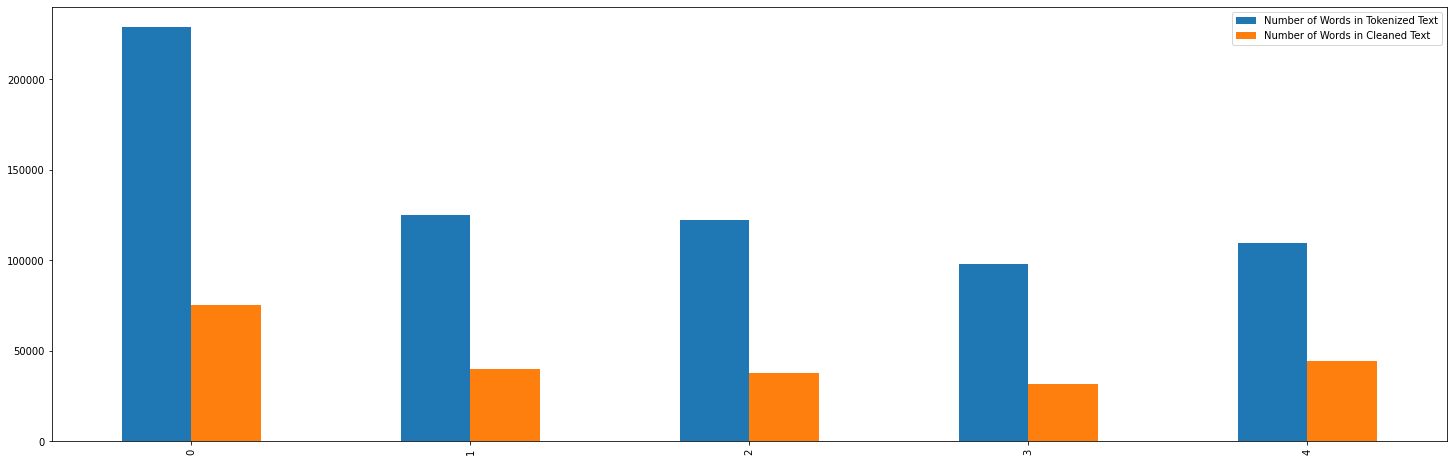

In [80]:
text_info = []
for a, t, tt, ct in zip(authors, titles, tokenized_texts, cleaned_texts):
    text_info.append((a, t, len(tt), len(ct)))

text_info_df = pd.DataFrame(text_info)
text_info_df = text_info_df.rename(columns={0: "Authors",
                                            1: "Titles",
                                            2: "Number of Words in Tokenized Text",
                                            3: "Number of Words in Cleaned Text"})
text_info_df.plot.bar()

**Create dataframe containing cleaned and tokenized samples**

In [34]:
labeled_texts_df = pd.DataFrame(labeled_texts)
labeled_texts_df = labeled_texts_df.rename(columns={0: "Cleaned Samples", 1: "Author"})
labeled_texts_df["Tokenized Samples"] = labeled_texts_df["Cleaned Samples"].apply(lambda x: word_tokenize(x))
labeled_texts_df["Number of Tokens"] = labeled_texts_df["Tokenized Samples"].apply(lambda x: len(x))
labeled_texts_df

,Cleaned Samples,Author,Tokenized Samples,Number of Tokens
0,action new window gave view road many advantag...,Elizabeth Gaskell,"[action, new, window, gave, view, road, many, ...",150
1,shook away deep voice place see thought sex pr...,Elizabeth Gaskell,"[shook, away, deep, voice, place, see, thought...",150
2,fire considering better lay motionless almost ...,Elizabeth Gaskell,"[fire, considering, better, lay, motionless, a...",150
3,harley bonnet got edith triumphantly knew suit...,Elizabeth Gaskell,"[harley, bonnet, got, edith, triumphantly, kne...",150
4,indeed weak indignation see unfair compressed ...,Elizabeth Gaskell,"[indeed, weak, indignation, see, unfair, compr...",150
...,...,...,...,...
995,shot downward southeastern limb storm almost r...,William R. Bradshaw,"[shot, downward, southeastern, limb, storm, al...",150
996,yogi juggler adept india magician sorcerer ast...,William R. Bradshaw,"[yogi, juggler, adept, india, magician, sorcer...",150
997,possessing creative energy boundless empire id...,William R. Bradshaw,"[possessing, creative, energy, boundless, empi...",150
998,ordinary meaning term high holy could worship ...,William R. Bradshaw,"[ordinary, meaning, term, high, holy, could, w...",150


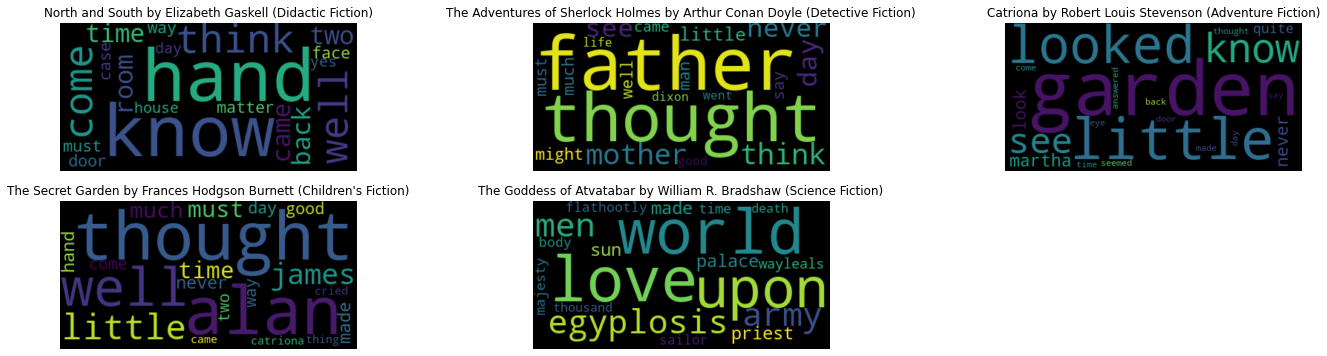

In [35]:
def find_most_common_words(text_df, authors):
    author_to_most_common_words = {}
    index = 0
    for r in text_df.groupby(["Author"])["Cleaned Samples"].apply(lambda x: " ".join(x)):
        words_to_count = (w for w in r.split(" "))
        words_to_count = [w for w in words_to_count if w]
        c = Counter(words_to_count).most_common(20)
        c = list(zip(*c))
        c = c[0]
        author_to_most_common_words[authors[index]] = c
        index += 1
    return author_to_most_common_words

def draw_word_cloud(words, titles, genres):
    plt.rcParams["figure.figsize"] = [24, 6]
    index = 1
    i = 0
    for key, value in words.items():
        wc = WordCloud().generate((" ").join(value))
        plt.subplot(2, 3, index)
        index += 1
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(titles[i] + " by " + key + " (" + genres[i] + ")")
        i += 1

most_common_words = find_most_common_words(labeled_texts_df, authors)
draw_word_cloud(most_common_words, titles, genres)

**Replace author names with numbers**

In [36]:
le = preprocessing.LabelEncoder()
le.fit(labeled_texts_df["Author"])
labeled_texts_df["Author"] = le.transform(labeled_texts_df["Author"])
labeled_texts_df = labeled_texts_df.sample(frac=1).reset_index(drop=True)
labeled_texts_df

,Cleaned Samples,Author,Tokenized Samples,Number of Tokens
0,house premise adjoining mean unable keep deed ...,1,"[house, premise, adjoining, mean, unable, keep...",150
1,icy peak pinnacle far eye could reach pierced ...,4,"[icy, peak, pinnacle, far, eye, could, reach, ...",150
2,winced away reference father child fully heart...,1,"[winced, away, reference, father, child, fully...",150
3,confronts golden throne seldom fortune behold ...,4,"[confronts, golden, throne, seldom, fortune, b...",150
4,come must weary long friend watson vital use s...,0,"[come, must, weary, long, friend, watson, vita...",150
...,...,...,...,...
995,ten lonely yet inside garden sound sound runni...,2,"[ten, lonely, yet, inside, garden, sound, soun...",150
996,ready equipped brisker mood usual mother round...,1,"[ready, equipped, brisker, mood, usual, mother...",150
997,wing remain motionless perceptibly ascend slow...,4,"[wing, remain, motionless, perceptibly, ascend...",150
998,lady standing showed emotion fluttering fear a...,1,"[lady, standing, showed, emotion, fluttering, ...",150


In [37]:
x_train = labeled_texts_df["Cleaned Samples"]
y_train = labeled_texts_df["Author"]

**Create bag-of-words and  tf–idf vectors**

In [38]:
# BOW
count_vect = CountVectorizer(analyzer="word")
count_vect.fit(x_train)
x_train_bow = count_vect.transform(x_train)

# TFIDF
tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r"\w{1,}", max_features=5000)
tfidf_vect.fit(x_train)
xtrain_tfidf_unigram = tfidf_vect.transform(x_train)

**Create doc2Vec vector**

In [39]:
msg_train_1, msg_test_1, label_train_1, label_test_1 = train_test_split(labeled_texts_df["Tokenized Samples"], labeled_texts_df["Author"], test_size=0.8)

# Add tag for training set
train_corpus = []
for value, tag in zip(msg_train_1.items(), label_train_1.items()):
    train_corpus.append(TaggedDocument(words=value[1], tags=[tag[1]]))

test_corpus = []
for value in msg_test_1.items():
    test_corpus.append(value[1])

# Set model for doc2vec
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

# Build vocabulary
model.build_vocab(train_corpus)

# Train model on corpus
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

# Infer vector
inferred_vector = []
for i in range(len(test_corpus)):
    inferred_vector.append(model.infer_vector(test_corpus[i]))

In [40]:
featured_x_train = [x_train_bow, xtrain_tfidf_unigram]

featured_x_name = {"BOW": ["K-means Clustering", "Hierarchical Clustering", "Gaussian Clustering"], "TFIDF Unigram": ["K-means Clustering", "Hierarchical Clustering", "Gaussian Clustering"]}

num_clusters = np.unique(labeled_texts_df["Author"]).shape[0]

**Define plotting methods**

In [41]:
def convert_author_to_num(predict_list, origin_list):
    list_of_tuple = []
    for num, tag in zip(predict_list, origin_list):
        list_of_tuple.append((num, tag))
    sorted_by_second = sorted(list_of_tuple, key=lambda tup: tup[1])
    list_0 = []
    list_1 = []
    list_2 = []
    list_3 = []
    list_4 = []
    for index in sorted_by_second:
        if index[1] == 0:
            list_0.append(index)
        if index[1] == 1:
            list_1.append(index)
        if index[1] == 2:
            list_2.append(index)
        if index[1] == 3:
            list_3.append(index)
        if index[1] == 4:
            list_4.append(index)
    counter_0 = Counter(list_0).most_common(1)
    counter_1 = Counter(list_1).most_common(1)
    counter_2 = Counter(list_2).most_common(1)
    counter_3 = Counter(list_3).most_common(1)
    counter_4 = Counter(list_4).most_common(1)
    list_of_author = [counter_0, counter_1, counter_2, counter_3, counter_4]
    author_to_num = {}
    for tup in list_of_author:
        author_to_num[tup[0][0][1]]=tup[0][0][0]

    return author_to_num

def plot_k_means(datapoint, kms, method, model):   
    plt.figure
    title = model + " with " + method
    plt.title(label=title, loc="center")
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=kms.labels_, cmap="rainbow")
    centroids = kms.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], s=100, c="black")
    plt.savefig(title + ".png", dpi=300)
    plt.show()
    
def convert_data_2_df_bow_tdidf(x_train_feature, predict):
    data = pd.DataFrame(x_train_feature)
    data.columns = ["x1", "x2"]
    data["Predicted Cluster"] = predict
    return data

def convert_data_2_df_word_embed(x_train_feature):
    data = pd.DataFrame(x_train_feature)
    data.columns=["x1", "x2"]
    data["cluster"] = label_test_1
    return data 

def plot_gaussian_mixture(data, method, model):
    plt.figure
    title = model + " with " + method
    plt.title(label=title, loc="center")
    sns.scatterplot(data=data, x="x1", y="x2", hue="Predicted Cluster", palette=["purple", "red", "blue", "green", "orange"])
    plt.savefig(title + ".png", dpi=300)
    plt.show()

def plot_hierarchical(data, method, model):
    plt.figure
    title = model + " with " + method
    plt.title(label=title, loc="center")
    dend = sch.dendrogram(sch.linkage(data, method="ward"))
    plt.savefig(title + ".png", dpi=300)
    plt.show()

**Generate, evaluate, and plot clusters (vectors: BOW, TFIDF;
models: K-means, hierarchical, Gaussian mixture;
scores: Cohen's kappa, silhouette, coherence, V-measure)**


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: D

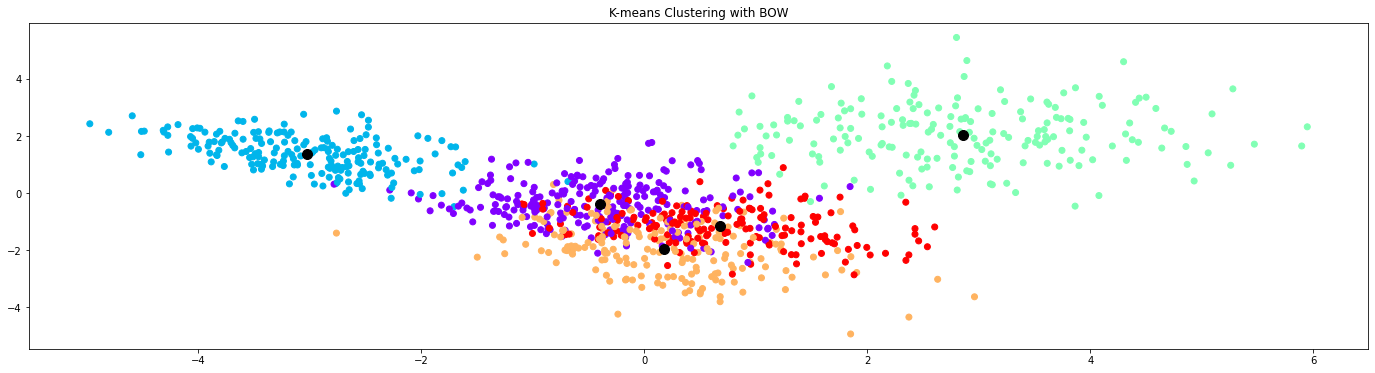

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gui

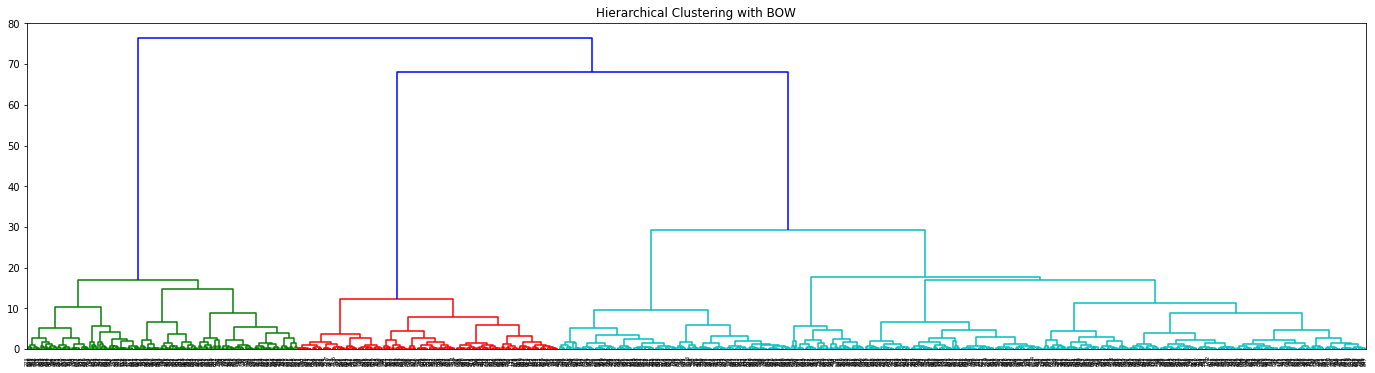

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gui

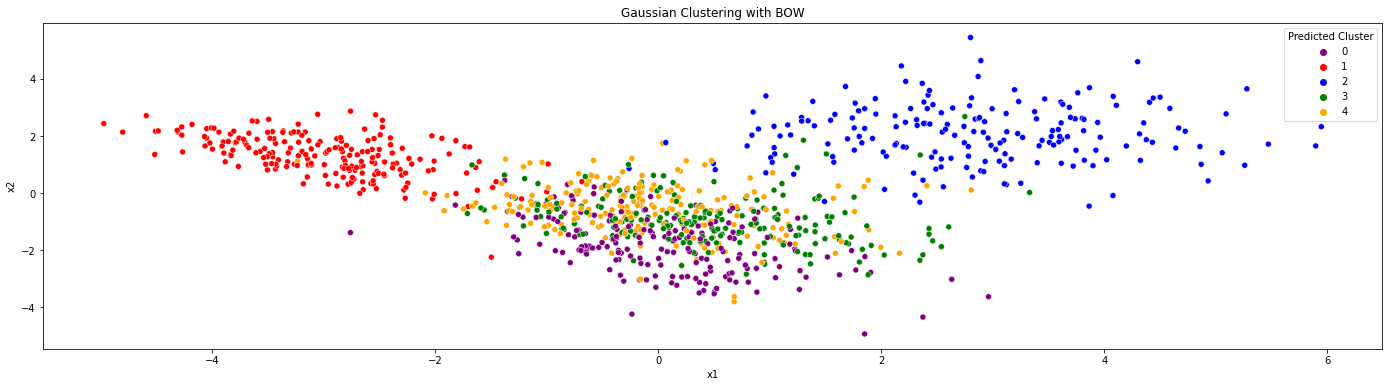

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gui

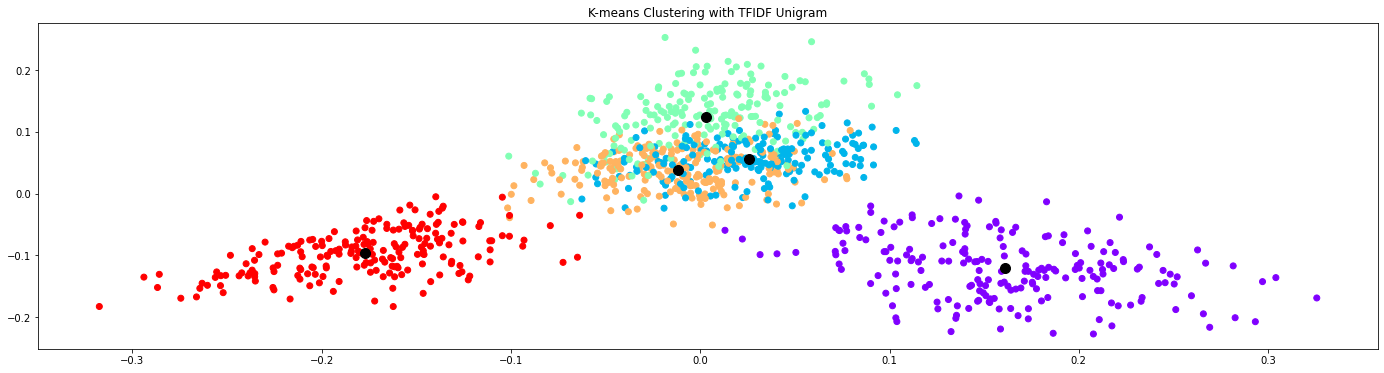

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gui

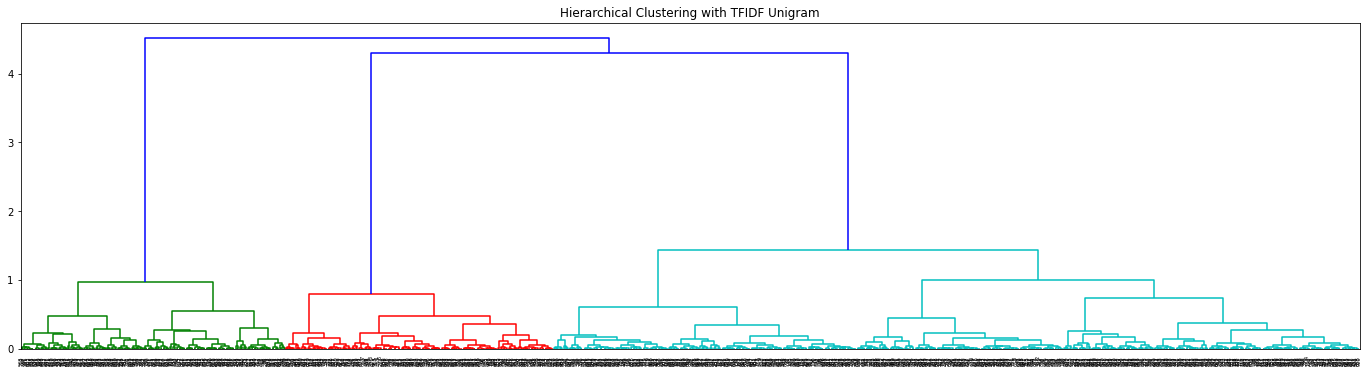

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gui

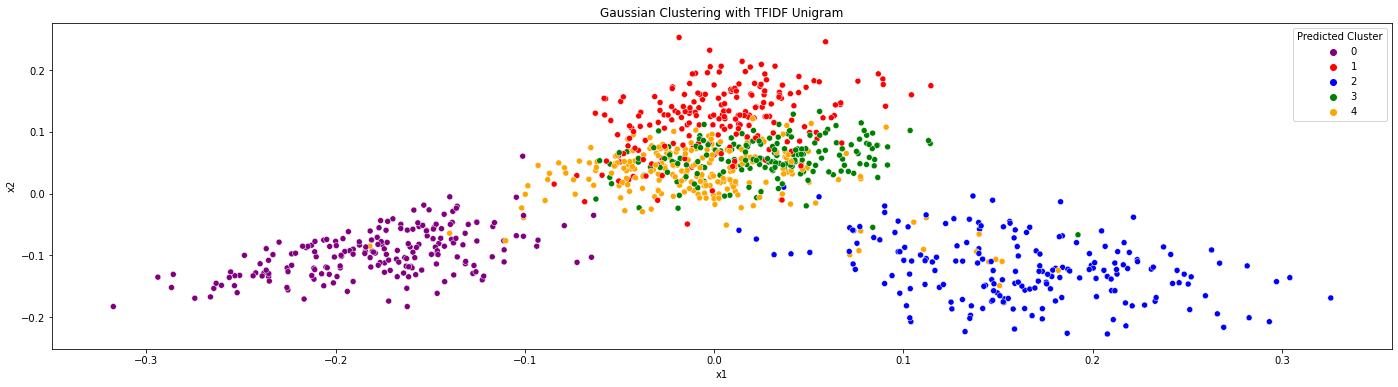

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gui

In [42]:
# Use PCA to reduce number of dimensions
pca = PCA(n_components=2)

count = 0

# K-means
km_kappa = []
km_silhouette = []
km_coherence = []
km_v_measure = []

# Hierarchical
agg_kappa = []
agg_silhouette = []
agg_coherence = []
agg_v_measure = []

# Gaussian mixture
gm_kappa = []
gm_silhouette = []
gm_coherence = []
gm_v_measure = []

for i, label in zip(featured_x_train, featured_x_name.keys()):
    # K-means
    kms = KMeans(n_clusters=num_clusters, init="k-means++", max_iter=100)
    kms.fit(i)
    plot_k_means(pca.fit_transform(i.todense()), kms, label, featured_x_name[label][count])
    dict_author_km = convert_author_to_num(kms.labels_, y_train)
    author_num_list_km = []
    for author in y_train:
        author_num_list_km.append(dict_author_km[author])
    km_kappa.append(metrics.cohen_kappa_score(author_num_list_km,  kms.labels_))
    km_silhouette.append(metrics.silhouette_score(i,  kms.labels_))
    km_coherence.append(metrics.normalized_mutual_info_score(y_train,  kms.labels_))
    km_v_measure.append(metrics.v_measure_score(y_train,  kms.labels_))
    count += 1

    # Hierarchical
    cluster = AgglomerativeClustering(n_clusters=num_clusters,  affinity="euclidean",  linkage="ward")
    cluster.fit(i.todense())
    plot_hierarchical(pca.fit_transform(i.todense()), label, featured_x_name[label][count])
    dict_author_hc = convert_author_to_num(cluster.labels_, y_train)
    author_num_list_hc = []
    for author in y_train:
        author_num_list_hc.append(dict_author_hc[author])
    agg_kappa.append(metrics.cohen_kappa_score(author_num_list_hc,  cluster.labels_))
    agg_silhouette.append(metrics.silhouette_score(i,  cluster.labels_))
    agg_coherence.append(metrics.normalized_mutual_info_score(y_train,  kms.labels_))
    agg_v_measure.append(metrics.v_measure_score(y_train,  kms.labels_))
    count += 1

    # Gaussian mixture
    gm = GaussianMixture(n_components= num_clusters,  covariance_type = "diag", random_state=42)
    gm.fit(i.toarray())
    data = convert_data_2_df_bow_tdidf(pca.fit_transform(i.todense()), cluster.labels_)
    plot_gaussian_mixture(data, label, featured_x_name[label][count])
    dict_author_gm = convert_author_to_num(gm.predict(i.toarray()), y_train)
    author_num_list_gm = []
    for author in y_train:
        author_num_list_gm.append(dict_author_gm[author])
    gm_kappa.append(metrics.cohen_kappa_score(author_num_list_gm,  gm.predict(i.toarray())))
    gm_silhouette.append(metrics.silhouette_score(i,  gm.predict(i.toarray())))
    gm_coherence.append(metrics.normalized_mutual_info_score(y_train,  gm.predict(i.toarray())))
    gm_v_measure.append(metrics.v_measure_score(y_train,  gm.predict(i.toarray())))
    count = 0

**Generate, evaluate, and plot clusters (vectors: word-embedding; models: K-means, hierarchical, Gaussian mixture; scores: Cohen's kappa, silhouette, coherence, V-measure)**

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: D

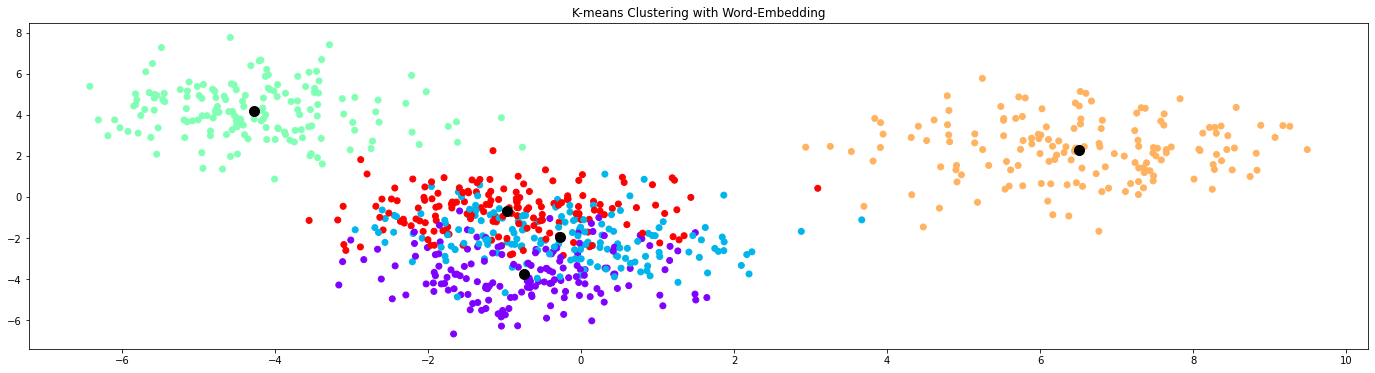

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

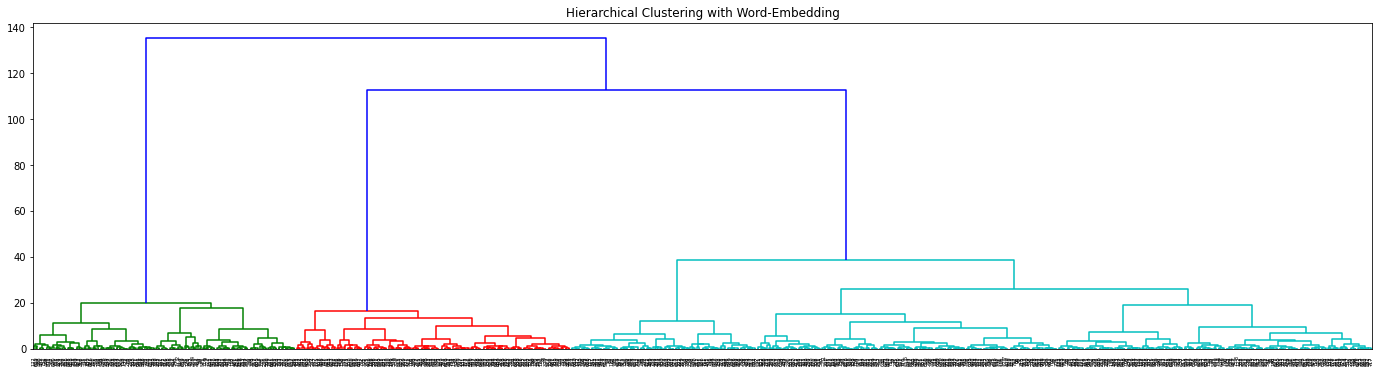

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

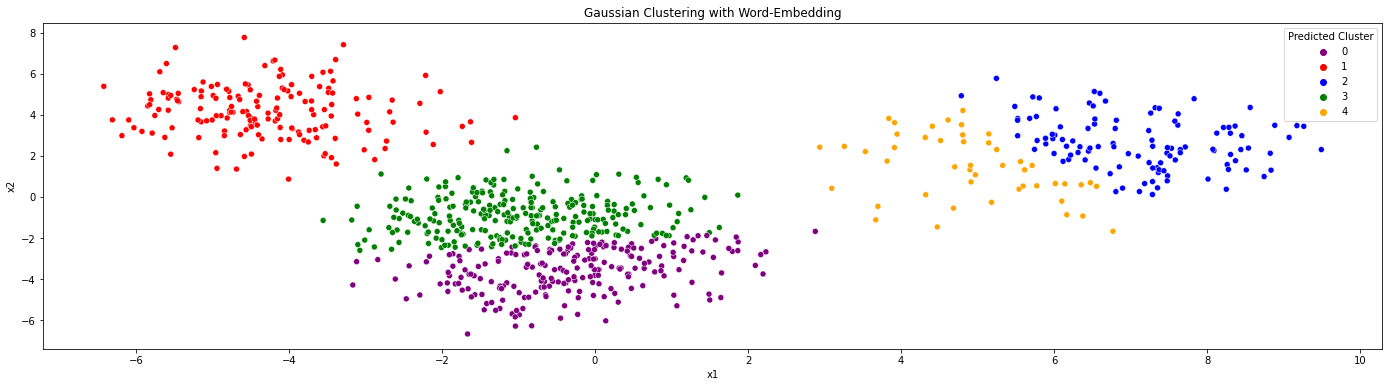

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

In [43]:
kms = KMeans(n_clusters=num_clusters, init="k-means++", max_iter=300, n_init=1, random_state=42, verbose=0)

# K-means
embed_pred = kms.fit_predict(inferred_vector)
pca = PCA(n_components=2).fit(inferred_vector)
Word2Vec_2D = pca.transform(inferred_vector)
plot_k_means(Word2Vec_2D, kms, "Word-Embedding", "K-means Clustering")
dict_author_we_1 = convert_author_to_num(embed_pred, label_test_1)
author_num_list = []
for author in label_test_1:
    author_num_list.append(dict_author_we_1[author])
km_kappa.append(metrics.cohen_kappa_score(author_num_list, embed_pred))
km_silhouette.append(metrics.silhouette_score(inferred_vector, embed_pred))
km_coherence.append(metrics.normalized_mutual_info_score(author_num_list, embed_pred))
km_v_measure.append(metrics.v_measure_score(author_num_list, embed_pred))

# Hierarchical
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
embed_cluster_pred = cluster.fit_predict(inferred_vector)
dict_author_we_2 = convert_author_to_num(embed_cluster_pred, label_test_1)
author_num_list = []
for author in label_test_1:
    author_num_list.append(dict_author_we_2[author])
plot_hierarchical(Word2Vec_2D, "Word-Embedding", "Hierarchical Clustering")
agg_kappa.append(metrics.cohen_kappa_score(author_num_list, embed_cluster_pred))
agg_silhouette.append(metrics.silhouette_score(inferred_vector, embed_cluster_pred))
agg_coherence.append(metrics.normalized_mutual_info_score(author_num_list, embed_cluster_pred))
agg_v_measure.append(metrics.v_measure_score(author_num_list, embed_cluster_pred))

# Gaussian mixture
gm = GaussianMixture(n_components=num_clusters, covariance_type="tied", random_state=42)
data = convert_data_2_df_word_embed(Word2Vec_2D)
embed_gm_pred = gm.fit_predict(data.iloc[:, :2])
data["Predicted Cluster"] = embed_gm_pred
dict_author_we_3 = convert_author_to_num(embed_gm_pred, label_test_1)
author_num_list = []
for author in label_test_1:
    author_num_list.append(dict_author_we_3[author])
plot_gaussian_mixture(data, "Word-Embedding", "Gaussian Clustering")
gm_kappa.append(metrics.cohen_kappa_score(author_num_list, embed_gm_pred))
gm_silhouette.append(metrics.silhouette_score(inferred_vector, embed_gm_pred))
gm_coherence.append(metrics.normalized_mutual_info_score(author_num_list, embed_gm_pred))
gm_v_measure.append(metrics.v_measure_score(author_num_list, embed_gm_pred))

**Present scores**

In [44]:
# Silhouette
evaluation = ["K-means silhouette", "Hierarchical silhouette", "Gaussian mixture silhouette"]
silhouette_results_df = pd.DataFrame((km_silhouette, agg_silhouette, gm_silhouette), columns=["BOW", "TFIDF Unigram", "Word-Embedding"])
silhouette_results_df["Evaluation"] = evaluation
silhouette_results_df.set_index("Evaluation")
first_col = silhouette_results_df.pop("Evaluation")
silhouette_results_df.insert(0, "Evaluation", first_col)
silhouette_results_df

,Evaluation,BOW,TFIDF Unigram,Word-Embedding
0,K-means silhouette,0.005330,0.014045,0.500360
1,Hierarchical silhouette,0.004777,0.013010,0.499149
2,Gaussian mixture silhouette,0.002625,0.009277,0.272527


In [45]:
# V-measure
evaluation = ["K-means V-measure", "Hierarchical V-measure", "Gaussian mixture V-measure"]
v_measure_results_df = pd.DataFrame((km_v_measure, agg_v_measure, gm_v_measure), columns=["BOW", "TFIDF Unigram", "Word-Embedding"])
v_measure_results_df["Evaluation"] = evaluation
v_measure_results_df.set_index("Evaluation")
first_col = v_measure_results_df.pop("Evaluation")
v_measure_results_df.insert(0, "Evaluation", first_col)
v_measure_results_df

,Evaluation,BOW,TFIDF Unigram,Word-Embedding
0,K-means V-measure,0.837355,0.969426,0.971226
1,Hierarchical V-measure,0.837355,0.969426,0.972759
2,Gaussian mixture V-measure,0.883946,0.771239,0.726672


In [46]:
# Kappa
evaluation = ["K-means kappa", "Hierarchical kappa", "Gaussian mixture kappa"]
kappa_results_df = pd.DataFrame((km_kappa, agg_kappa, gm_kappa), columns=["BOW", "TFIDF Unigram", "Word-Embedding"])
kappa_results_df["Evaluation"] = evaluation
kappa_results_df.set_index("Evaluation")
first_col = kappa_results_df.pop("Evaluation")
kappa_results_df.insert(0, "Evaluation", first_col)
kappa_results_df

,Evaluation,BOW,TFIDF Unigram,Word-Embedding
0,K-means kappa,0.90875,0.985000,0.989062
1,Hierarchical kappa,0.91000,0.945000,0.990624
2,Gaussian mixture kappa,0.94625,0.835999,0.743196


In [47]:
# Coherence
evaluation = ["K-means coherence", "Hierarchical coherence", "Gaussian mixture coherence"]
coherence_results_df = pd.DataFrame((km_coherence, agg_coherence, gm_coherence), columns=["BOW", "TFIDF Unigram", "Word-Embedding"])
coherence_results_df["Evaluation"] = evaluation
coherence_results_df.set_index("Evaluation")
first_col = coherence_results_df.pop("Evaluation")
coherence_results_df.insert(0, "Evaluation", first_col)
coherence_results_df

,Evaluation,BOW,TFIDF Unigram,Word-Embedding
0,K-means coherence,0.837355,0.969426,0.971226
1,Hierarchical coherence,0.837355,0.969426,0.972759
2,Gaussian mixture coherence,0.883946,0.771239,0.726672


**Plot scores**

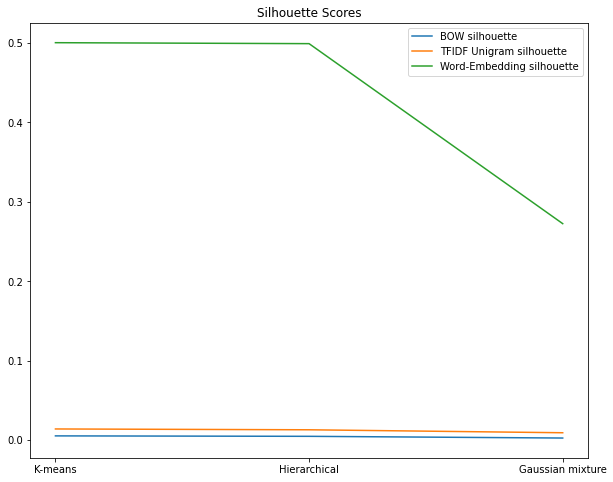

In [48]:
# Silhouette
models = ["K-means", "Hierarchical", "Gaussian mixture"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models, [km_silhouette[0], agg_silhouette[0], gm_silhouette[0]], label="BOW silhouette")
plt.plot(models, [km_silhouette[1], agg_silhouette[1], gm_silhouette[1]], label="TFIDF Unigram silhouette")
plt.plot(models, [km_silhouette[2], agg_silhouette[2], gm_silhouette[2]], label="Word-Embedding silhouette")
plt.legend()
plt.title("Silhouette Scores")
plt.savefig("silhoutte.png", dpi=300)
plt.show()

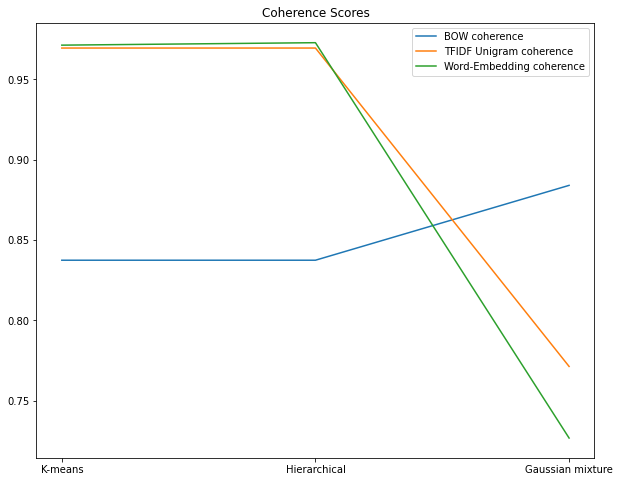

In [49]:
# Coherence
models = ["K-means", "Hierarchical", "Gaussian mixture"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models, [km_coherence[0], agg_coherence[0], gm_coherence[0]], label="BOW coherence")
plt.plot(models, [km_coherence[1], agg_coherence[1], gm_coherence[1]], label="TFIDF Unigram coherence")
plt.plot(models, [km_coherence[2], agg_coherence[2], gm_coherence[2]], label="Word-Embedding coherence")
plt.legend()
plt.title("Coherence Scores")
plt.savefig("coherence.png", dpi=300)
plt.show()

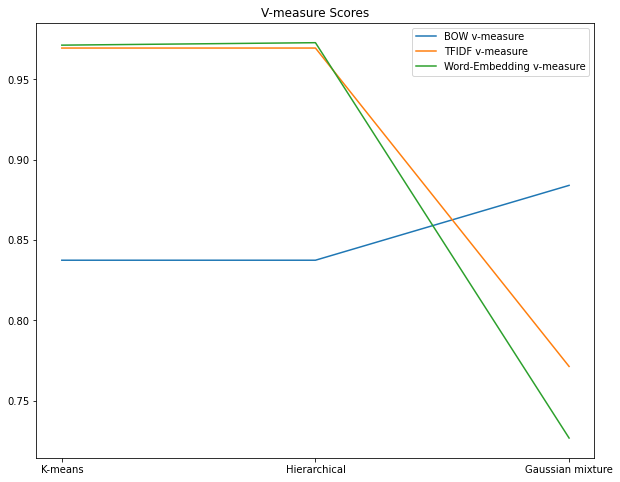

In [50]:
# V-measure
models = ["K-means", "Hierarchical", "Gaussian mixture"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models, [km_v_measure[0], agg_v_measure[0], gm_v_measure[0]], label="BOW v-measure")
plt.plot(models, [km_v_measure[1], agg_v_measure[1], gm_v_measure[1]], label="TFIDF v-measure")
plt.plot(models, [km_v_measure[2], agg_v_measure[2], gm_v_measure[2]], label="Word-Embedding v-measure")
plt.legend()
plt.title("V-measure Scores")
plt.savefig("v-measure.png", dpi=300)
plt.show()

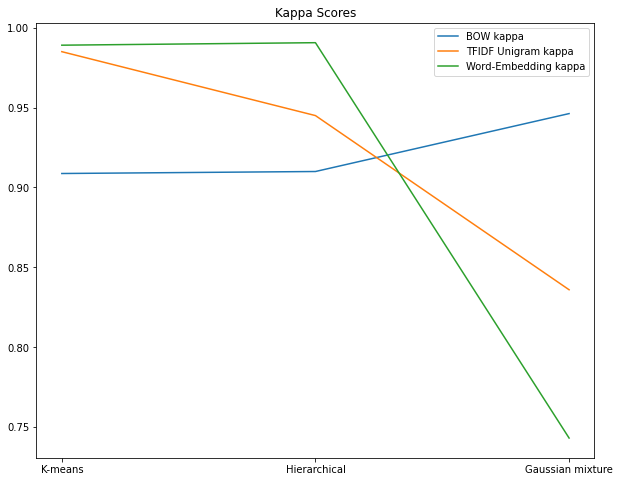

In [51]:
# Kappa
models = ["K-means", "Hierarchical", "Gaussian mixture"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models, [km_kappa[0], agg_kappa[0], gm_kappa[0]], label="BOW kappa")
plt.plot(models, [km_kappa[1], agg_kappa[1], gm_kappa[1]], label="TFIDF Unigram kappa")
plt.plot(models, [km_kappa[2], agg_kappa[2], gm_kappa[2]], label="Word-Embedding kappa")
plt.legend()
plt.title("Kappa Scores")
plt.savefig("kappa.png", dpi=300)
plt.show()

**Create LDA model**

In [52]:
df_tok = labeled_texts_df["Tokenized Samples"]

bigram = Phrases(df_tok, min_count=20)
for tdx in range(len(df_tok)): 
  for tokens in bigram[df_tok[tdx]]:
    if "_" in tokens: 
      df_tok[tdx].append(tokens)

dictionary = Dictionary(df_tok)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus_matrix = [dictionary.doc2bow(BookWords) for BookWords in df_tok]

temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(corpus=corpus_matrix, num_topics=num_clusters, id2word=id2word, passes=50, chunksize=2000, alpha="auto", eta="auto", iterations=400, eval_every=None)

top_topics = model.top_topics(corpus_matrix)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  Phrases detected in `sentences`. Return type depends on the `as_tuples` parameter.


In [53]:
model.print_topics()

[(0,
  '0.008*"thought" + 0.008*"well" + 0.008*"alan" + 0.007*"james" + 0.007*"little" + 0.007*"must" + 0.007*"hand" + 0.007*"time" + 0.007*"never" + 0.007*"made"'),
 (1,
  '0.009*"enemy" + 0.009*"wayleals" + 0.009*"gun" + 0.008*"army" + 0.007*"could" + 0.007*"men" + 0.007*"spear" + 0.006*"made" + 0.006*"vessel" + 0.006*"fleet"'),
 (2,
  '0.010*"garden" + 0.009*"little" + 0.009*"looked" + 0.009*"know" + 0.008*"see" + 0.007*"look" + 0.007*"martha" + 0.007*"never" + 0.007*"quite" + 0.007*"thought"'),
 (3,
  '0.007*"think" + 0.006*"well" + 0.006*"day" + 0.006*"father" + 0.006*"never" + 0.006*"thought" + 0.005*"came" + 0.005*"shall" + 0.005*"hand" + 0.005*"much"'),
 (4,
  '0.009*"love" + 0.008*"world" + 0.007*"egyplosis" + 0.006*"like" + 0.006*"palace" + 0.006*"priest" + 0.006*"sun" + 0.005*"earth" + 0.005*"people" + 0.005*"upon"')]

In [54]:
pprint(model.print_topics())

[(0,
  '0.008*"thought" + 0.008*"well" + 0.008*"alan" + 0.007*"james" + '
  '0.007*"little" + 0.007*"must" + 0.007*"hand" + 0.007*"time" + 0.007*"never" '
  '+ 0.007*"made"'),
 (1,
  '0.009*"enemy" + 0.009*"wayleals" + 0.009*"gun" + 0.008*"army" + '
  '0.007*"could" + 0.007*"men" + 0.007*"spear" + 0.006*"made" + 0.006*"vessel" '
  '+ 0.006*"fleet"'),
 (2,
  '0.010*"garden" + 0.009*"little" + 0.009*"looked" + 0.009*"know" + '
  '0.008*"see" + 0.007*"look" + 0.007*"martha" + 0.007*"never" + 0.007*"quite" '
  '+ 0.007*"thought"'),
 (3,
  '0.007*"think" + 0.006*"well" + 0.006*"day" + 0.006*"father" + 0.006*"never" '
  '+ 0.006*"thought" + 0.005*"came" + 0.005*"shall" + 0.005*"hand" + '
  '0.005*"much"'),
 (4,
  '0.009*"love" + 0.008*"world" + 0.007*"egyplosis" + 0.006*"like" + '
  '0.006*"palace" + 0.006*"priest" + 0.006*"sun" + 0.005*"earth" + '
  '0.005*"people" + 0.005*"upon"')]


**Perform LDA vectorization**

In [55]:
labeled_texts_df_lda = labeled_texts_df.copy()

# Find number of topics
min_df = 5 # Minimum number for document frequency in the corpus
rm_top = 5 # Remove top frequent words 
workers = 4

hdp_model = HDPModel(min_df=min_df, rm_top=rm_top)
hdp_model.optim_interval = 5
for d in labeled_texts_df_lda["Cleaned Samples"]:
  hdp_model.add_doc(d)
hdp_model.burn_in = 100
hdp_model.train(0, workers=workers)
for i in range(0, 1000, 10):
  hdp_model.train(10, workers=workers)
  print(f"Iterations: {i}\tlog-likelyhood: {hdp_model.ll_per_word}\tnumber of topics: {hdp_model.live_k}")
num_topics = hdp_model.live_k

Iterations: 0	log-likelyhood: -2.915481916331029	number of topics: 2
Iterations: 10	log-likelyhood: -2.9037931324708235	number of topics: 2
Iterations: 20	log-likelyhood: -2.893628752244654	number of topics: 2
Iterations: 30	log-likelyhood: -2.8873013949433357	number of topics: 2
Iterations: 40	log-likelyhood: -2.88031560256137	number of topics: 2
Iterations: 50	log-likelyhood: -2.874134060327772	number of topics: 2
Iterations: 60	log-likelyhood: -2.8694158565333647	number of topics: 2
Iterations: 70	log-likelyhood: -2.863088409092561	number of topics: 2
Iterations: 80	log-likelyhood: -2.8569129395699844	number of topics: 3
Iterations: 90	log-likelyhood: -2.8532185900407745	number of topics: 3
Iterations: 100	log-likelyhood: -2.8457445913839834	number of topics: 2
Iterations: 110	log-likelyhood: -2.8417980744710065	number of topics: 2
Iterations: 120	log-likelyhood: -2.8385991056916104	number of topics: 2
Iterations: 130	log-likelyhood: -2.834091738717391	number of topics: 2
Iterations

In [56]:
# Average topic coherence is the sum of topic coherences of all topics divided by the number of topics
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print("Average topic coherence: %.4f." % avg_topic_coherence)
pprint(top_topics)

Average topic coherence: -3.4176.
[([(0.009628076, 'garden'),
   (0.0089343395, 'little'),
   (0.0087947585, 'looked'),
   (0.008571003, 'know'),
   (0.007996033, 'see'),
   (0.007467501, 'look'),
   (0.00731803, 'martha'),
   (0.0071217795, 'never'),
   (0.007042625, 'quite'),
   (0.0069062267, 'thought'),
   (0.0067422367, 'come'),
   (0.006649307, 'made'),
   (0.006191908, 'back'),
   (0.0060642273, 'door'),
   (0.0056591993, 'seemed'),
   (0.005393089, 'time'),
   (0.0053927526, 'say'),
   (0.005383229, 'eye'),
   (0.005171632, 'day'),
   (0.0051487545, 'way')],
  -1.0338983646581386),
 ([(0.008270501, 'thought'),
   (0.008230413, 'well'),
   (0.007964469, 'alan'),
   (0.007196068, 'james'),
   (0.0071835606, 'little'),
   (0.0071151615, 'must'),
   (0.007111535, 'hand'),
   (0.0070776045, 'time'),
   (0.006819876, 'never'),
   (0.006729897, 'made'),
   (0.006668033, 'much'),
   (0.006557134, 'good'),
   (0.0064338767, 'day'),
   (0.0061617903, 'way'),
   (0.006053861, 'come'),
   

**Visualize clusters**

In [57]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model,  corpus_matrix,  dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.045898  0.019316       1        1  37.976154
2      0.112537 -0.071953       2        1  23.832195
0      0.056887  0.065485       3        1  20.571522
4     -0.129422 -0.054729       4        1  12.337137
1     -0.085901  0.041881       5        1   5.282991, topic_info=        Term        Freq       Total Category  logprob  loglift
558     alan  166.000000  166.000000  Default  30.0000  30.0000
1184  martha  183.000000  183.000000  Default  29.0000  29.0000
361   garden  267.000000  267.000000  Default  28.0000  28.0000
374     love  193.000000  193.000000  Default  27.0000  27.0000
41      like  297.000000  297.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
220      two   29.060875  429.989001   Topic5  -5.2155   0.2463
157     time   29.336855  464.357033   Topic5  -5.2061   0.1789
133    might   23.160347  435.856722   Topic5  -5.4425   0.0058
113     even   22.356223  330.280117   Topic5  -5.4778   0.2478
266     must   20.447343  514.460166   Topic5  -5.5671  -0.2846

[329 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1329      4  0.153103    admiral
1329      5  0.803789    admiral
1309      3  0.998952   advocate
956       4  0.950553     aerial
558       3  0.996482       alan
...     ...       ...        ...
98        4  0.110195        yet
98        5  0.051857        yet
1152      1  0.176023        yon
1152      3  0.792105        yon
1186      2  0.981307  yorkshire

[870 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

**Transform BOW vector using LDA**

In [58]:
lda = LDA(n_components=25, n_jobs=1)
array_lda_Bow = lda.fit_transform(x_train_bow)
X_lda_Bow = pd.DataFrame(array_lda_Bow)
X_lda_Bow

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000265,0.000265,0.982757,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,...,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265
1,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.993642,0.000265,0.000265,...,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265
2,0.000265,0.205345,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,...,0.000265,0.191218,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265
3,0.000265,0.196552,0.000265,0.000265,0.350597,0.000265,0.000265,0.326538,0.000265,0.000265,...,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265
4,0.000265,0.000265,0.072821,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,...,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.106831,0.503623,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,...,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.383718,0.000265
996,0.000265,0.173446,0.542444,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,...,0.000265,0.000265,0.278282,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265
997,0.000265,0.130986,0.000265,0.000265,0.000265,0.000265,0.000265,0.100658,0.000265,0.000265,...,0.000265,0.000265,0.000265,0.762528,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265
998,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,...,0.000265,0.000265,0.993642,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265


**Transform TFIDF vector using LDA**

In [59]:
lda = LDA(n_components=25, n_jobs=1)
array_lda_Tfid = lda.fit_transform(xtrain_tfidf_unigram)
X_lda_Tfid = pd.DataFrame(array_lda_Tfid)
X_lda_Tfid

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.215382,0.003471,0.003471,...,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.704794,0.003471,0.003471,0.003471
1,0.004364,0.004364,0.004364,0.004364,0.004364,0.004364,0.148019,0.050539,0.004364,0.004364,...,0.004364,0.004364,0.004364,0.004364,0.287550,0.004364,0.422260,0.004364,0.004364,0.004364
2,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,...,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.904968,0.003960,0.003960,0.003960
3,0.003551,0.003551,0.003551,0.003551,0.003551,0.003551,0.003551,0.031175,0.003551,0.003551,...,0.003551,0.003551,0.003551,0.003551,0.378830,0.003551,0.511877,0.003551,0.003551,0.003551
4,0.023939,0.003585,0.003585,0.003585,0.003585,0.013543,0.030682,0.037935,0.003585,0.003585,...,0.045525,0.003585,0.025266,0.003585,0.033763,0.003585,0.625668,0.003585,0.003585,0.087681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.003800,0.003800,0.003800,0.003800,0.003800,0.036922,0.003800,0.012125,0.003800,0.003800,...,0.068350,0.003800,0.003800,0.003800,0.100107,0.022901,0.624307,0.003800,0.003800,0.003800
996,0.003752,0.014773,0.003752,0.003752,0.014773,0.003752,0.003752,0.051461,0.003752,0.003752,...,0.003752,0.003752,0.003752,0.003752,0.034155,0.003752,0.809791,0.003752,0.003752,0.003752
997,0.003887,0.003887,0.100885,0.003887,0.003887,0.003887,0.003887,0.122412,0.003887,0.003887,...,0.003887,0.003887,0.003887,0.003887,0.200192,0.003887,0.431395,0.003887,0.003887,0.003887
998,0.003753,0.003753,0.003753,0.003753,0.034603,0.003753,0.003753,0.062987,0.003753,0.003753,...,0.181979,0.003753,0.003753,0.003753,0.003753,0.003753,0.568337,0.003753,0.077029,0.003753


**Generate and plot K-means + LDA-BOW clusters**

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: D

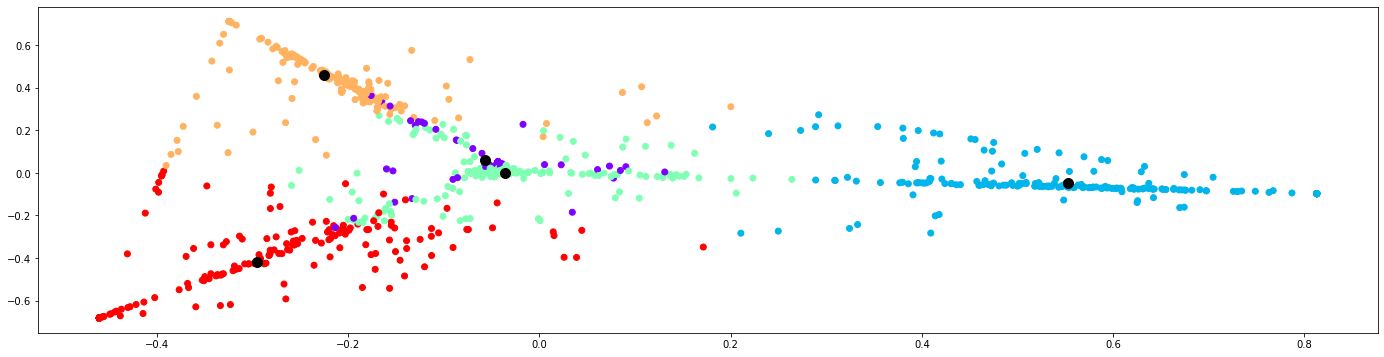

In [60]:
# K-means + LDA-BOW
kmeans_model = KMeans(n_clusters=5, init="k-means++", max_iter=100) 
X = kmeans_model.fit_predict(X_lda_Bow)
pca = PCA(n_components=2).fit(X_lda_Bow)
datapoint = pca.transform(X_lda_Bow)
plt.figure
plt.scatter(datapoint[:, 0],  datapoint[:, 1], c=kmeans_model.labels_, cmap="rainbow")
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], s=100, c="black")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: D

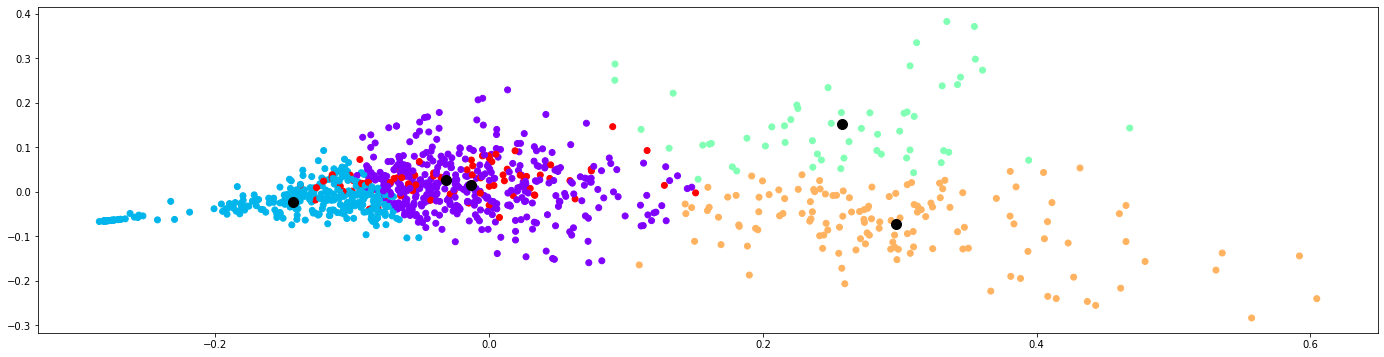

In [61]:
# K-means + LDA-TFIDF
kmeans_model = KMeans(n_clusters=5, init="k-means++", max_iter=100) 
X = kmeans_model.fit_predict(X_lda_Tfid)
pca = PCA(n_components=2).fit(X_lda_Tfid)
datapoint = pca.transform(X_lda_Tfid)
plt.figure
plt.scatter(datapoint[:, 0],  datapoint[:, 1], c=kmeans_model.labels_, cmap="rainbow")
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], s=100, c="black")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: D

3    361
1    205
2    188
0    183
4     63
Name: Label, dtype: int64

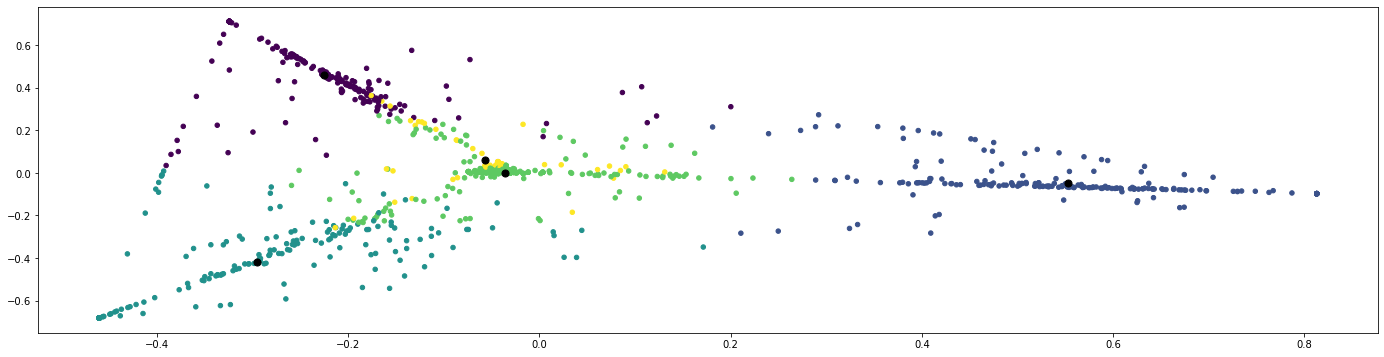

In [62]:
# Documents per cluster in K-means + LDA-BOW
pred_ldabow = kmeans_model.fit_predict(array_lda_Bow)
reduced_featureslda = pca.fit_transform(array_lda_Bow)
reduced_cluster = pca.transform(kmeans_model.cluster_centers_)
plt.scatter(reduced_featureslda[:, 0], reduced_featureslda[:, 1], s=20, c=pred_ldabow)
plt.scatter(reduced_cluster[:, 0], reduced_cluster[:, 1], s = 50, c="black", label="Centroids")
doc_per_cluster = pd.DataFrame(pred_ldabow)
doc_per_cluster = doc_per_cluster.rename(columns={0: "Label"})
doc_per_cluster["Label"].value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: D

3    442
2    289
4    124
0     88
1     57
Name: Label, dtype: int64

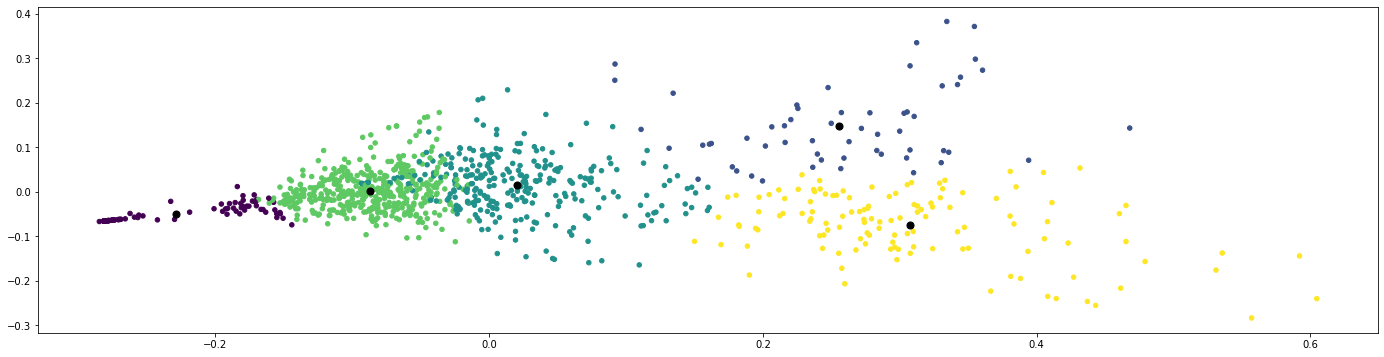

In [63]:
# Documents per cluster in K-means + LDA-TFIDF
pred_ldatfid = kmeans_model.fit_predict(array_lda_Tfid)
reduced_featureslda = pca.fit_transform(array_lda_Tfid)
reduced_cluster = pca.transform(kmeans_model.cluster_centers_)
plt.scatter(reduced_featureslda[:, 0], reduced_featureslda[:, 1], s=20,  c=pred_ldatfid)
plt.scatter(reduced_cluster[:, 0], reduced_cluster[:, 1], s=50, c="black", label="Centroids")
doc_per_cluster = pd.DataFrame(pred_ldatfid)
doc_per_cluster = doc_per_cluster.rename(columns={0: "Label"})
doc_per_cluster["Label"].value_counts()

**Generate and plot Hierarchical + LDA-BOW clusters**

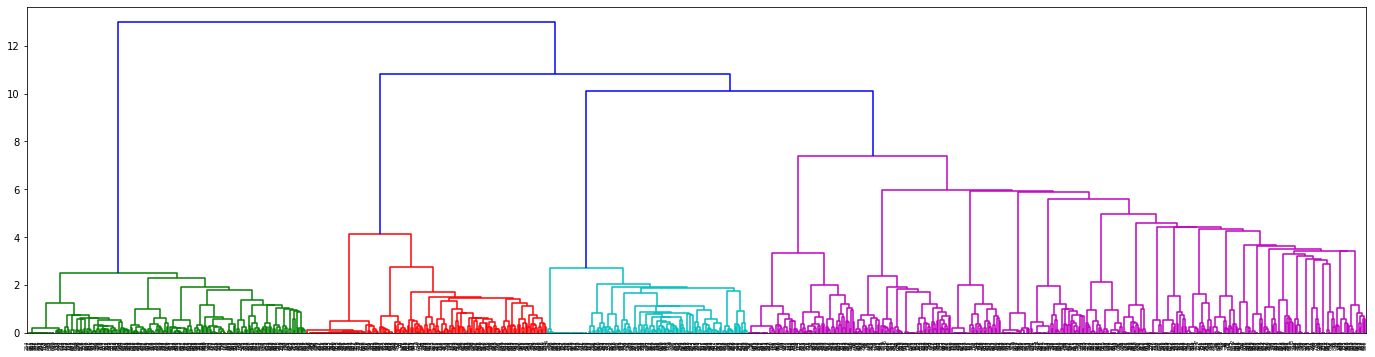

In [64]:
# Hierarchical + LDA-BOW
# Create dendrogram
dendrogram = sch.dendrogram(sch.linkage(X_lda_Bow, method="ward"))
# Create clusters
hc = AgglomerativeClustering(n_clusters=num_topics, affinity="euclidean", linkage="ward")
# Save clusters
y_hc = hc.fit_predict(X_lda_Bow)

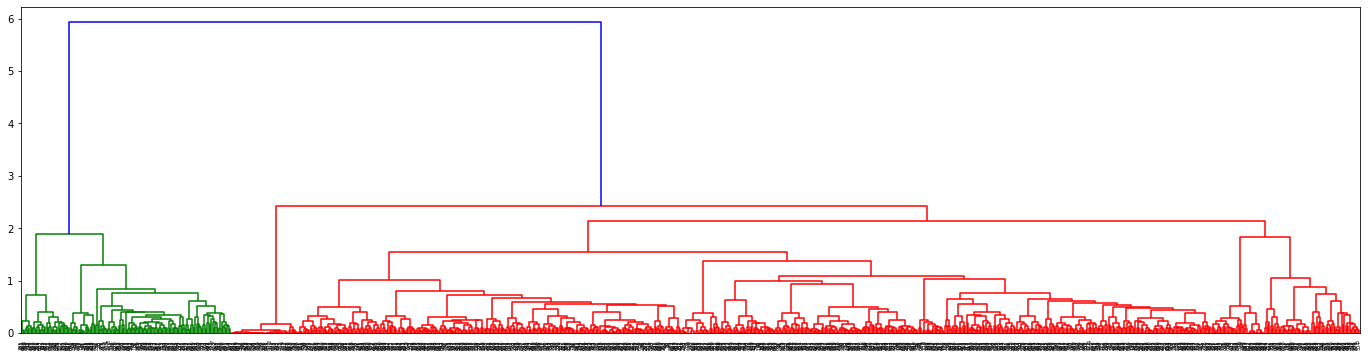

In [65]:
# Hierarchical + LDA-TFIDF
# Create dendrogram
dendrogram = sch.dendrogram(sch.linkage(X_lda_Tfid, method="ward"))
# Create clusters
hc = AgglomerativeClustering(n_clusters=num_topics, affinity="euclidean", linkage="ward")
# Save clusters
y_hc = hc.fit_predict(X_lda_Tfid)

**Generate scores**

In [66]:
coherence_model_lda = CoherenceModel(model=model, texts=df_tok, dictionary=dictionary, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence score: {coherence_lda}")

Coherence score: 0.4942801002434165


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum

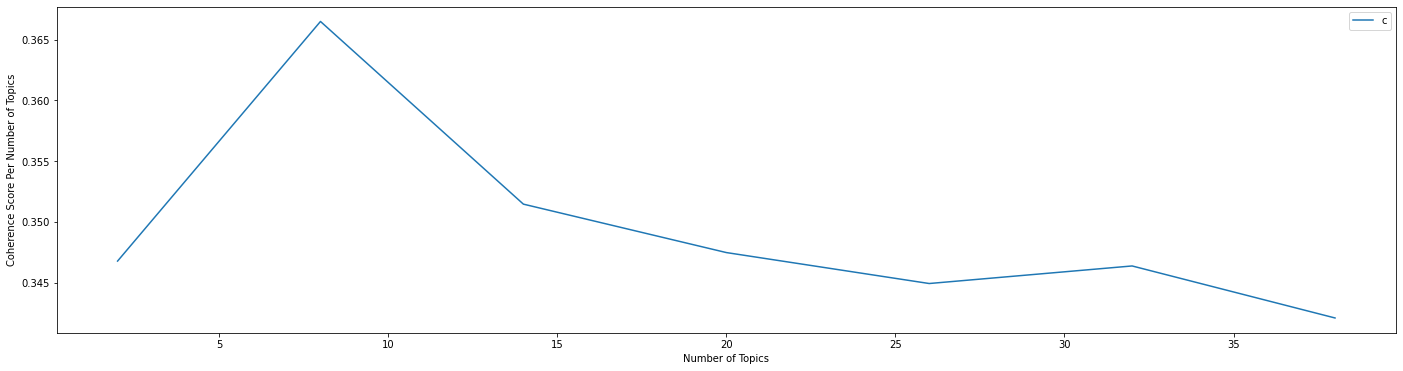

In [67]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_matrix, texts=df_tok, start=2, limit=40, step=6)

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score Per Number of Topics")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [68]:
lda_bow_sil_scr = silhouette_score(array_lda_Bow, pred_ldabow)
lda_tdidf_sil_scr = silhouette_score(array_lda_Tfid, pred_ldatfid)
lda_bow_hom_scr = homogeneity_score(y_train, pred_ldabow)
lda_tdidf_hom_scr = homogeneity_score(y_train, pred_ldatfid)

sil_scores = [lda_bow_sil_scr, lda_tdidf_sil_scr]
hom_scores = [lda_bow_hom_scr, lda_tdidf_hom_scr]

evaluation = ["Silhouette score", "Homogeneity score"]
lda_results_df = pd.DataFrame((sil_scores, hom_scores), columns=["BOW + LDA", "TFIDF + LDA"])
lda_results_df["Evaluation"] = evaluation
lda_results_df.set_index("Evaluation")
first_col = lda_results_df.pop("Evaluation")
lda_results_df.insert(0, "Evaluation", first_col)
lda_results_df

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: D

,Evaluation,BOW + LDA,TFIDF + LDA
0,Silhouette score,0.304599,0.163606
1,Homogeneity score,0.463407,0.248077


**Perform error analysis on K-means + BOW**

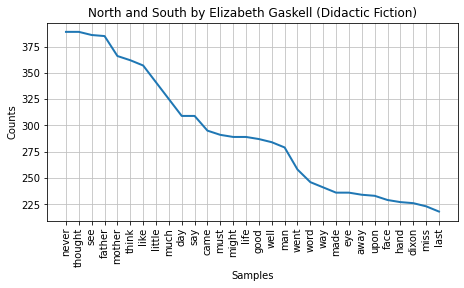

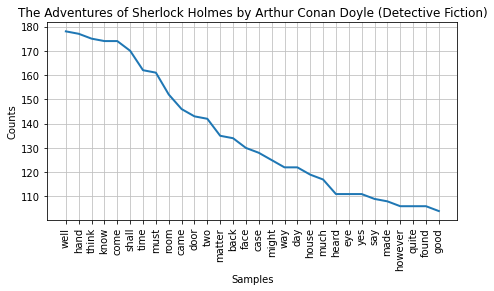

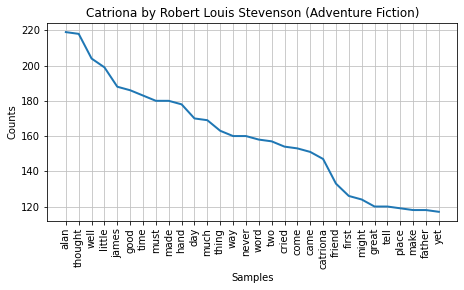

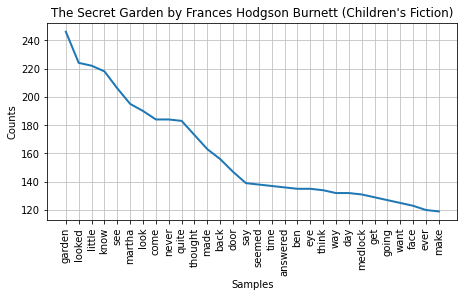

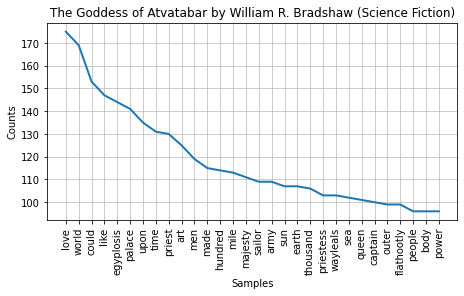

In [69]:
# Frequency distribution of words in cleaned texts
author_to_top_words = {}
plt.rcParams["figure.figsize"] = [25, 8]
index = 1
for t, a, ct, g in zip(titles, authors, cleaned_texts, genres):
    plt.subplot(2, 3, index)
    index += 1
    freq_dist = FreqDist(ct)
    author_to_top_words[a] = freq_dist.most_common(30)
    title = f"{t} by {a} ({g})"
    freq_dist.plot(30, cumulative=False, title=title)
    plt.show()

In [72]:
# K-means + BOW
cluster_num_to_top_words_dict = {}
print("K-means + BOW: Top terms per Cluster:")
order_centroids = kms.fit(x_train_bow).cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(5):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :30]]
    cluster_num_to_top_words_dict[i] = top_ten_words

columns = []
for t, a, g in zip(titles, authors, genres):
  temp_str = t + " by " + a + " (" + g + ")"
  columns.append(temp_str)

top_words_df = pd.DataFrame(cluster_num_to_top_words_dict)
top_words_df.columns = columns
top_words_df

K-means + BOW: Top terms per Cluster:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:58: D

,North and South by Elizabeth Gaskell (Didactic Fiction),The Adventures of Sherlock Holmes by Arthur Conan Doyle (Detective Fiction),Catriona by Robert Louis Stevenson (Adventure Fiction),The Secret Garden by Frances Hodgson Burnett (Children's Fiction),The Goddess of Atvatabar by William R. Bradshaw (Science Fiction)
0,father,love,hand,garden,alan
1,thought,world,well,little,thought
2,think,like,come,looked,well
3,mother,could,know,know,james
4,never,upon,shall,see,little
5,see,egyplosis,think,martha,time
6,like,men,came,look,never
7,day,army,two,quite,must
8,little,palace,time,never,much
9,say,priest,must,come,good


In [73]:
top_words_df.keys()

Index(['North and South by Elizabeth Gaskell (Didactic Fiction)',
       'The Adventures of Sherlock Holmes by Arthur Conan Doyle (Detective Fiction)',
       'Catriona by Robert Louis Stevenson (Adventure Fiction)',
       'The Secret Garden by Frances Hodgson Burnett (Children's Fiction)',
       'The Goddess of Atvatabar by William R. Bradshaw (Science Fiction)'],
      dtype='object')

In [74]:
common_words = defaultdict(int)

for key in range(5):
  for value in range(30):
    common_words[cluster_num_to_top_words_dict[key][value]] += 1

In [75]:
common_words

defaultdict(int,
            {'alan': 1,
             'answered': 1,
             'army': 1,
             'art': 1,
             'away': 2,
             'back': 2,
             'ben': 1,
             'body': 1,
             'came': 3,
             'case': 1,
             'catriona': 1,
             'chapter': 1,
             'come': 3,
             'could': 1,
             'cried': 1,
             'day': 4,
             'death': 1,
             'dixon': 1,
             'door': 2,
             'earth': 1,
             'egyplosis': 1,
             'eye': 3,
             'face': 3,
             'father': 1,
             'first': 1,
             'flathootly': 1,
             'friend': 1,
             'garden': 1,
             'get': 1,
             'going': 1,
             'good': 3,
             'great': 1,
             'hand': 2,
             'heard': 1,
             'house': 1,
             'hundred': 1,
             'james': 1,
             'know': 2,
             'last': 2,
          

In [79]:
common_words_df = pd.DataFrame(common_words.items())
common_words_df.columns = ["Word", "Count"]
common_words_df = common_words_df.sort_values(by="Count", ascending=False)
common_words_df.set_index("Word", inplace=True)
common_words_df = common_words_df.transpose()
common_words_df

Word,made,day,way,much,time,might,eye,never,little,say,...,thousand,art,mile,death,people,earth,power,chapter,royal,yet
Count,5,4,4,4,4,3,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1


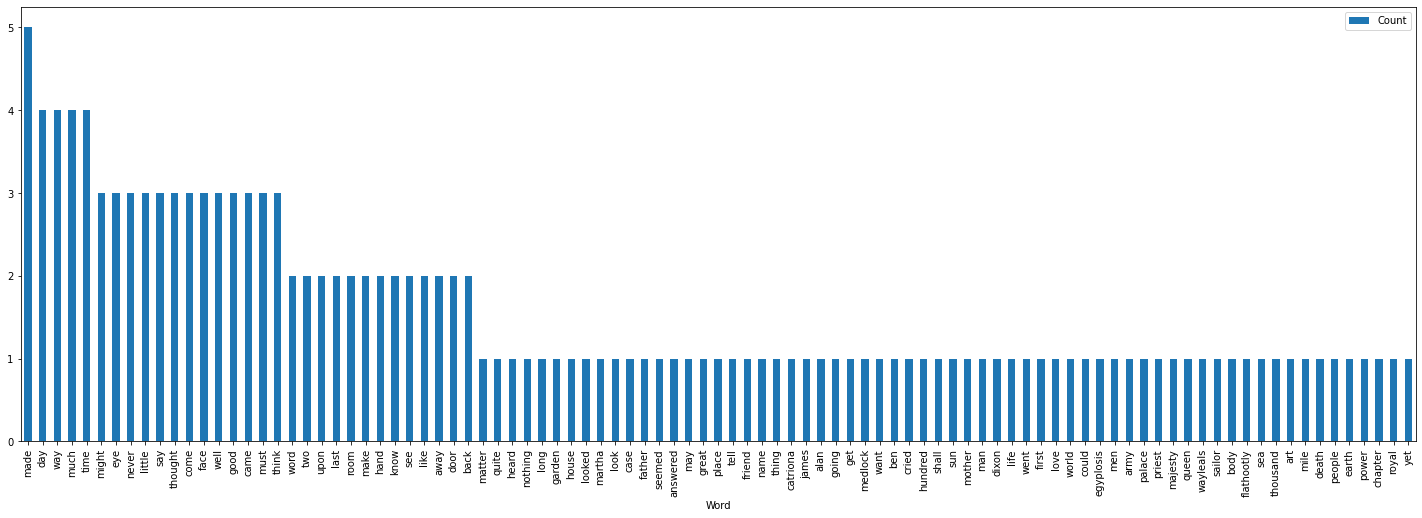

In [77]:
ax = common_words_df.plot.bar(rot=90, y="Count")